In [ ]:
!pip install gpustat

  Using cached gpustat-1.1.1-py3-none-any.whl
  Using cached nvidia_ml_py-12.550.52-py3-none-any.whl (39 kB)
  Using cached blessed-1.20.0-py2.py3-none-any.whl (58 kB)


In [ ]:
!gpustat

ae22cfe56c9c  Mon Apr 29 20:13:27 2024  535.104.05
[0] Tesla T4 | 42°C,   0 % |     0 / 15360 MB |


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30510 sha256=f846e871507934dbbcb86c4ff2cc42a5936186c860b0291d266b629f44bd55b0
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19455 sha256=847d51f92c6c8dd7979db25b75427fe97687d873428572dd92d23e240054d6be
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=965bf2d2dc9d1b5b8ed94b150e99daf5c0ce5098ed8b2eaecd44a5e81e78ac26
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

**Importing necessary libraries**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import namedtuple
from sklearn import preprocessing
from bert import bert_tokenization
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.15.0
Hub version:  0.16.1


**Importing Dataset**

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/NLP_Dataset/hindi_preprocessed_2.csv')


In [ ]:
# Columns
df.columns

Index(['text', 'task_1'], dtype='object')

In [ ]:
#rename column name
df.rename(columns={'task_1': 'label'}, inplace=True)


In [ ]:
# Print hate rows
rows_with_label_0 = df[df['label'] == 0]
print(rows_with_label_0.head())


                                                text  label
3                     आसमानी किताब के नाजायज औलाद है      0
5  बिहार की आम जनता को बहुत ही नाराजगी है केंद्र ...      0
6  यही तेरी असलियत है कि चोरी रोज करेगा खेत मे ले...      0
7  भोजपुरी का  टके का सिंगर किसी के लड़की का नाम ...      0
9                                        मूर्ख लड़की      0


In [ ]:
#drop null values
df= df.dropna()

In [ ]:
df['label']

0       1
1       1
2       1
3       0
4       1
       ..
4589    1
4590    1
4591    1
4592    1
4593    0
Name: label, Length: 4594, dtype: int64

**Convert labels to one-hot encoding and in required shape**

In [ ]:
import numpy as np

# Convert labels to one-hot encoding
num_classes = 2
labels_one_hot = np.zeros((df['label'].size, num_classes))
labels_one_hot[np.arange(df['label'].size), df['label']] = 1
print("Updated shape of label_one_hot:", labels_one_hot.shape)

Updated shape of label_one_hot: (4594, 2)


**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and temporary sets (80% training, 20% temp)
train_x, temp_x, train_y, temp_y = train_test_split(df['text'], labels_one_hot, test_size=0.2, random_state=42)

# Further split the temporary set into validation and testing sets (50% validation, 50% testing)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=42)

**Functions to create input features**

In [ ]:
# Function to create input_ids
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

# Function to create attention masks
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

# Function to create segment ids
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

# Function to create input_ids, attention_masks, segment_ids for sample
def create_single_input(sentence,MAX_LEN, MAX_SEQ_LEN):

  stokens = tokenizer.tokenize(sentence)

  stokens = stokens[:MAX_LEN]

  stokens = ["[CLS]"] + stokens + ["[SEP]"]

  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids,masks,segments

def create_input_array(sentences, MAX_SEQ_LEN):

  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):

    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2, MAX_SEQ_LEN)

    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32),
            np.asarray(input_masks, dtype=np.int32),
            np.asarray(input_segments, dtype=np.int32)]

**Importing Muril Model Layer**

In [ ]:
# MuRIL model layer
muril_layer = hub.KerasLayer("https://tfhub.dev/google/MuRIL/1", trainable=True)

# Create tokenizer
vocab_file = muril_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = muril_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

**Defining train_x, test_x, val_x**

In [ ]:
# Create input_ids, attention_masks, segment_ids for training and validation sets with max_seq_len as 128
max_seq_len = 128
train_x = create_input_array(train_x, max_seq_len)
val_x = create_input_array(val_x, max_seq_len)
test_x=create_input_array(test_x, max_seq_len)

100%|██████████| 460/460 [00:00<00:00, 2747.14it/s]


**Define Model Function**

In [ ]:
# # Define model function - compile and fit
import tensorflow as tf

def model_fit(train_x, train_y, val_x, val_y, max_seq_length, num_epochs, muril_layer):

    # Define input layers
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

    # Muril layer
    outputs = muril_layer(dict(input_word_ids=input_word_ids, input_mask=input_mask, input_type_ids=segment_ids))

    # Dropout layer
    x = tf.keras.layers.Dropout(0.2)(outputs["pooled_output"])

    # Output layer for binary classification
    final_output = tf.keras.layers.Dense(2, activation="softmax", name="dense_output")(x)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=final_output)

     # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    # Fit the model
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=16, validation_data=(val_x, val_y), shuffle=True)

    return model


**Set Epochs and Fit Model**

In [ ]:
# Set number of epochs
num_epochs = 3

# Get the model object
model = model_fit(train_x, train_y, val_x, val_y, max_seq_len, num_epochs, muril_layer)

230/230 [==============================] - 156s 495ms/step - loss: 0.6175 - accuracy: 0.6778 - val_loss: 0.5237 - val_accuracy: 0.7647
Epoch 2/3
230/230 [==============================] - 114s 496ms/step - loss: 0.4988 - accuracy: 0.7850 - val_loss: 0.4532 - val_accuracy: 0.8126
Epoch 3/3
230/230 [==============================] - 114s 497ms/step - loss: 0.4173 - accuracy: 0.8321 - val_loss: 0.4443 - val_accuracy: 0.8148


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 keras_layer (KerasLayer)    {'default': (None, 768),     2375562   ['input_mask[0][0]',      

**Testing Phase**

In [ ]:
# Make predictions
preds = model.predict(test_x)

15/15 [==============================] - 5s 295ms/step


In [ ]:
from sklearn.metrics import f1_score

# After training the model using model_fit function

# 1. Make predictions on the validation set
pred_probs = model.predict(test_x)

# 2. Convert predicted probabilities to class labels
pred_labels = np.argmax(pred_probs, axis=1)

# 3. Calculate F1 score
f1 = f1_score(np.argmax(test_y, axis=1), pred_labels)

print("F1 Score:", f1)


15/15 [==============================] - 4s 299ms/step
F1 Score: 0.8579970104633783


In [ ]:
pred_labels

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,

In [ ]:
import numpy as np

# Assuming pred_labels contains the predicted labels
num_ones = np.count_nonzero(pred_labels == 1)

print("Number of predicted 1s:", num_ones)


Number of predicted 1s: 363


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.51      0.62       154
           1       0.79      0.94      0.86       306

    accuracy                           0.79       460
   macro avg       0.80      0.72      0.74       460
weighted avg       0.80      0.79      0.78       460



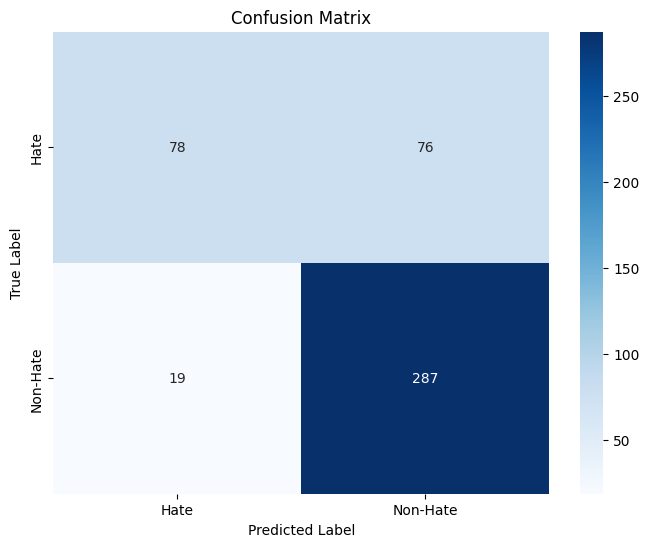

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# # Convert true labels to class labels
true_labels = np.argmax(test_y, axis=1)

# Generate classification report
report = classification_report(true_labels, pred_labels)

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print("Classification Report:")
print(report)


# Plot the confusion matrix
label_names = ['Hate','Non-Hate']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()